# Time Series Analysis Final Report
###   Brand: Chipotle
#### Annie Frenette
#### Advanced Stats in Advertising

In [1]:
import matplotlib.dates as mdates
import matplotlib.pyplot as pyplot
import pandas as pd
import numpy as np
from statsmodels.tsa import seasonal
from fbprophet  import Prophet
import holidays  #keeps track of when the holidays are each year. Past holidays and future holidays
from datetime import date 
from statsmodels.tsa import stattools
import seaborn as sns
from statistics import mode 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoLarsCV
import warnings 
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')
from sklearn.linear_model import Ridge

In [2]:
##- Read in the data that was previously pulled from Google's API. This data is also stationary
chipotle=pd.read_csv('Chipotle_GoogleTrends.csv', parse_dates=['period'])

In [3]:
## Format the Data and set the Index to be the Date.
chipotle['period']=chipotle['period'].dt.date

##Make the index of the DF be the date.
chipotle.set_index('period',inplace=True)

# Initial Seasonality Graphs
##### In the following code blocks, I will assess the seasonality of the Google Trend's data for Chipotle Mexican Grill. This data was previously made stationary after being pulled from Google's API. I differentiated the data so each occurence represents the difference between the previous occurence. I will decompose the model using the statsmodel package for python. This will allow for the model to show seasonality. By decomposing this model, I will be able to answer the following questions:
    
  ##### What is the overall trend? Is the search interest for your brand steadily growing?
        
  ##### What does the seasonality look like for this brand?

FIGURE 1
This graph gives an overview of what the google trends data looks like over the entire dataset


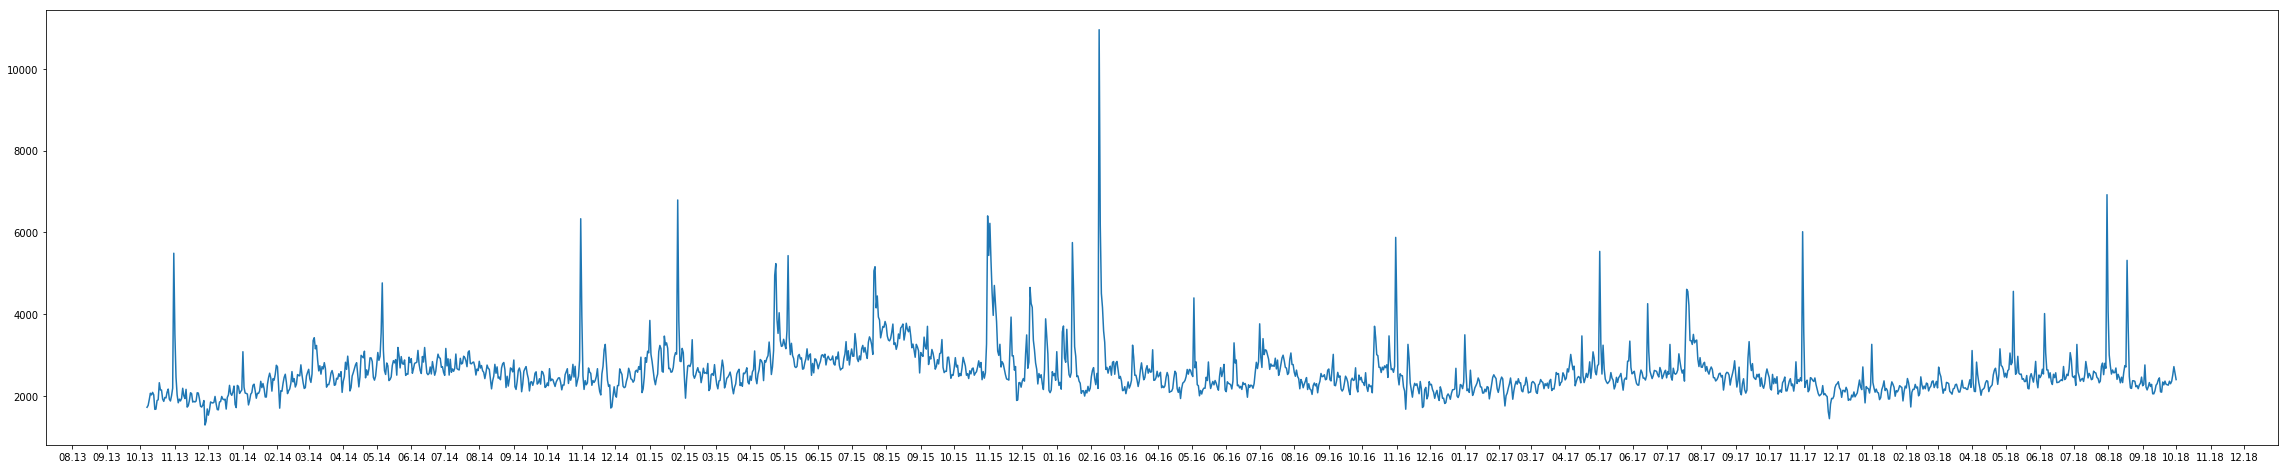

In [4]:
###--Set up the Graph---
###- This graph shows the changes in Google Search Trend over time
print('FIGURE 1')
print('This graph gives an overview of what the google trends data looks like over the entire dataset')
dimensions=(40,8)
fig, ax = pyplot.subplots(figsize=dimensions)

years = mdates.YearLocator()
months= mdates.MonthLocator()
yearmonth =mdates.DateFormatter('%m.%y')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(yearmonth)

ax.plot(chipotle.index,chipotle['value'])


In [5]:
##Decompose the Model
decompose_model=seasonal.seasonal_decompose(chipotle['value'].tolist(),freq=365, model='additive')

dir(decompose_model)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'nobs',
 'observed',
 'plot',
 'resid',
 'seasonal',
 'trend']

FIGURE 2
The first graph describes the Google Trends Value Over Time
The second graph describes the Trend of Google Searches throughout our Time Period
The third graph is an initial attempt at describing the seasonality of Google Trends for Chipotle
The final graph is is the residual values


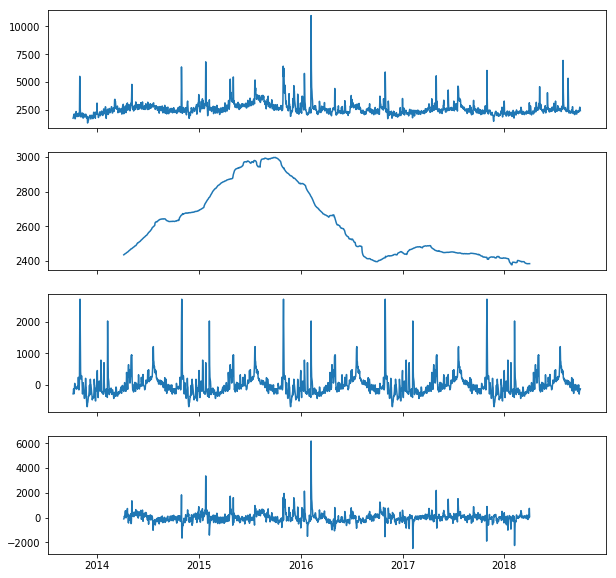

In [6]:
dimensions=(10,10)
fig, (ax1, ax2, ax3, ax4) = pyplot.subplots(4,figsize=dimensions, sharex='all')
print('FIGURE 2')
print('The first graph describes the Google Trends Value Over Time')
ax1.plot(chipotle.index, chipotle['value'])
print ('The second graph describes the Trend of Google Searches throughout our Time Period')
ax2.plot(chipotle.index, decompose_model.trend) #graphs the trend
print ('The third graph is an initial attempt at describing the seasonality of Google Trends for Chipotle')
ax3.plot(chipotle.index, decompose_model.seasonal) #overfit, fixed for the seasonaility. Not necessarily the true seasonaility. Model built for every day of the year and tries to explain the unexplained residuals
print ('The final graph is is the residual values')
ax4.plot(chipotle.index, decompose_model.resid) #what's left. The amount we were off each day in th model 


FIGURE 3
The purpose of the following analysis is to determine the seasonality of the trend. This graph will showcase the seasonal
trend of 2015 but it should be representative of the way Chipotle's Google Trend varies throughout a calendar year.


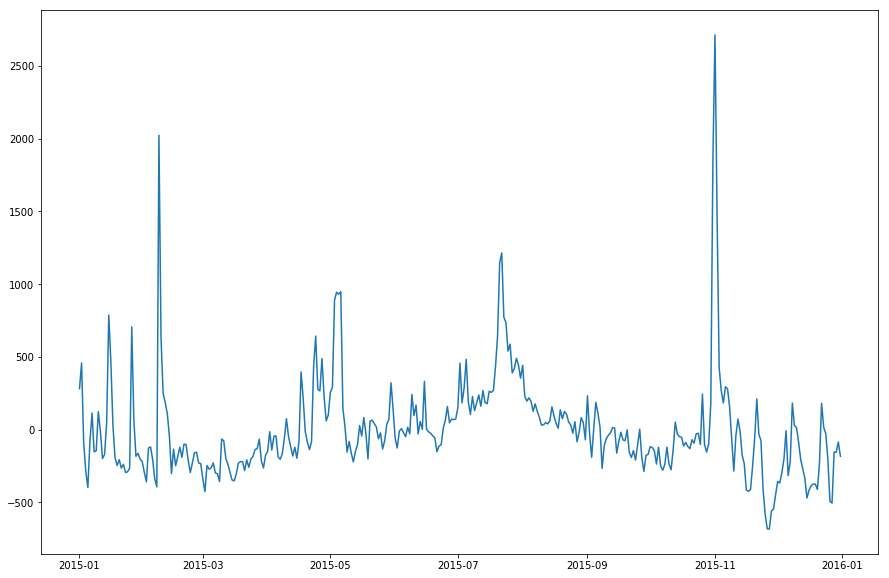

In [7]:
##Decompose the model to have a better idea of seasonal trend 
print('FIGURE 3')
print("The purpose of the following analysis is to determine the seasonality of the trend. This graph will showcase the seasonal") 
print("trend of 2015 but it should be representative of the way Chipotle's Google Trend varies throughout a calendar year.")
chipotle['seasonal']=decompose_model.seasonal

startdate= pd.to_datetime("2015-01-01").date() # turn a string into a datetim
enddate= pd.to_datetime("2015-12-31").date()

onyear = chipotle.loc[startdate:enddate] #slicing a dateframe by the date

dimensions = (15,10)
fix, ax1 = pyplot.subplots(figsize=dimensions)
pyplot.plot(onyear.index, onyear.seasonal)

# Analysis of  The Decomposed Time Series Analysis
## Question 1 - What is the overall trend? Is the search interest for your brand steadily growing?
#### When looking at the graph (figure 2, Graph 2) of the overall trend of Google Searches throughout the entire period of the dataset there seems to be a decrease in search interest in  2016 after a period of steady growth in 2014 & 2015. In 2016 the search interest took a deep dive before very slightly increasing at the end of the year. From 2017- present it seems that the search interest has remained consistent with small peaks and valleys. 

## Question 2- What does the seasonality look like for this brand?
#### When examining the seasonality graph (figure 3) there are many ebbs and flows in the google search interest. There seems to be many peaks of high interest but very few valleys of low interest. The most interesting peaks are in the middle of February, beginning of May, beginning of July and end of October/ early november. The one noticeable valley is sometime in the middle of November and December. Outside of these peaks and valleys, the search interest seems to remain pretty constant with small monthly changes. There are smaller peaks and valleys that exist but overall the value of search interest remains around the same.

## Question 3- Is the seasonality driven by the product or consumers? 
#### With a brand like Chipotle and the products only being able to satisfy consumer's momentary needs or desires, the seasonality is probably driven by both product and the consumer. For instance the desire to search for your nearest chipotle in the times of the year where you want a hearty filling meal is driven by the product. Additionally, on holidays such as Cinco De Mayo or Halloween, the characteristics of a Chipotle meal are driving the interest. On the other hand, there are instances in which the habits of a consumer may drive seasonality. Chipotle is a fast-casual food solution and is easy to be consumed on the go. There are times of the year,such as the summer, in which the average consumer is busier and requires a fast alternative. 


# Time Series Analysis with Facebook Prophet Tool
##### In the following section, I will evaluate the Time Series Graph using FB Prophet, created by Facebook.  This will forecast what the Google Trends Interest will be over the next calendar year. First I will do this without incorporating holidays and then I will repeat the same steps using holidays. The incorporation of holidays will aim to reduce the amount of error in the model.


In [8]:
prophetdataframe=pd.DataFrame() # Initialize FB Prophet DataFrame. This tool requires specific formatting of the dataframe
chipotle = pd.read_csv('Chipotle_GoogleTrends.csv',parse_dates=['period']) ## REREAD IN CSV as we made chnages to the Chipotle DataFrame above

In [9]:
prophetdataframe['ds']=chipotle['period'] #FB Prophet requires a datestamp and a value to compare with the dates. In our instance we will use the Google Trend's Value.
prophetdataframe['y'] = chipotle['value'] 

In [10]:
m = Prophet() #create a model that we will later use to forecast

In [11]:
m.fit(prophetdataframe) ###fit the model to the DataFrame we created that is specific to Prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [12]:
future = m.make_future_dataframe(periods=365) #prepare a dataframe that will hold our Forecasted/predicted values.

In [13]:
forecast = m.predict(future)

#### The following graph is a graph of the forecast. The black dots represent the observed values, the light blue is the 95% confidence interval of the model. The dark blue represents the error of the model.

FIGURE 4


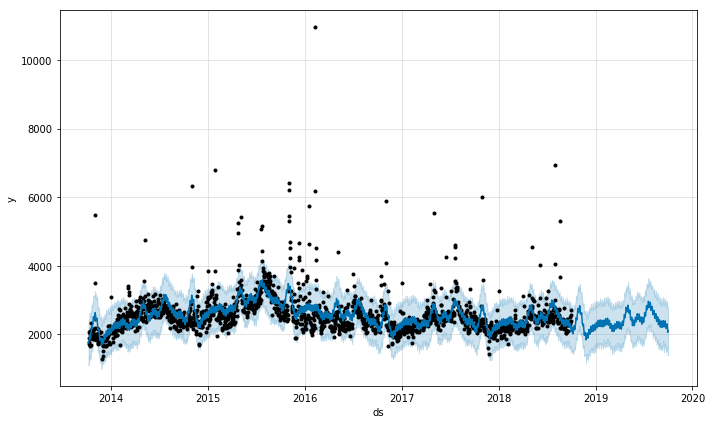

In [14]:
print('FIGURE 4')
fig1 = m.plot(forecast) ## black dots are observed values, trend values for those days. darkets shade of blue- the error in observation. The thicker the dark blue the more error 
## in an ideal world you see no dark blue
##light blue- confidence interval at 95th PCTILE
## we want to see our observed values in th elight blue. If they are it's a bad model. THey fell outside of the range

#### The following graphs represent the components of the forecasted model. The first graph is the overal trend, the second graph represents the holidays.The third graph represents the weekly trend of search interest. The final graph is the predicted trend for the next calendar year.

FIGURE 5


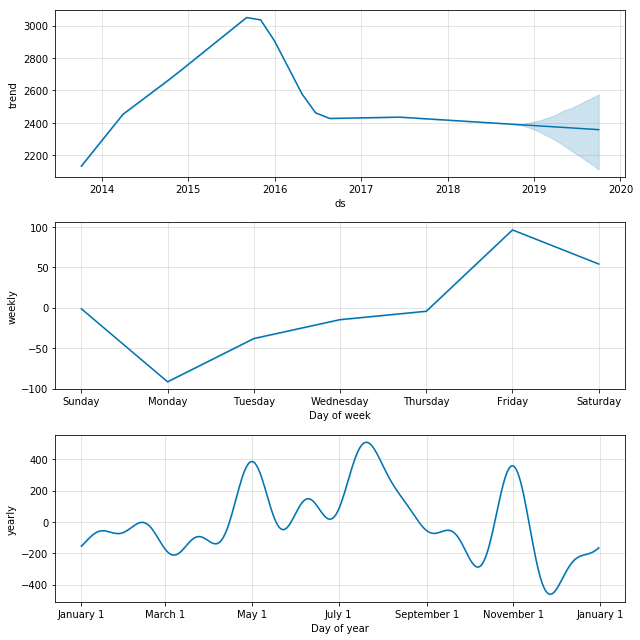

In [15]:
print('FIGURE 5')
fig2 = m.plot_components(forecast)

### Error Analysis of Fb Prophet Model
#### Analyzing the amount of error in the model. By evaluating the value of the residuals and dividing by the length of the error there will be an error term. I will create a dataframe that holds these residual values. 

In [16]:
erroranalysis = m.predict(prophetdataframe)


erroranalysis['value']= prophetdataframe['y']
erroranalysis['residuals'] = erroranalysis['value'] - erroranalysis['yhat']
erroranalysis['absoluteresidual'] =  abs(erroranalysis['residuals'])

erroranalysis.head()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,...,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,value,residuals,absoluteresidual
0,2013-10-07,2133.200947,1115.079338,2352.852970,2133.200947,2133.200947,-379.646042,-379.646042,-379.646042,-91.582363,...,-288.063679,-288.063679,-288.063679,0.0,0.0,0.0,1753.554905,1718.421074,-35.133831,35.133831
1,2013-10-08,2135.024357,1190.550375,2410.806823,2135.024357,2135.024357,-323.779474,-323.779474,-323.779474,-38.097644,...,-285.681830,-285.681830,-285.681830,0.0,0.0,0.0,1811.244883,1765.208236,-46.036647,46.036647
2,2013-10-09,2136.847766,1218.192294,2461.088899,2136.847766,2136.847766,-293.806789,-293.806789,-293.806789,-14.748444,...,-279.058345,-279.058345,-279.058345,0.0,0.0,0.0,1843.040977,1906.278566,63.237590,63.237590
3,2013-10-10,2138.671176,1238.818150,2496.232248,2138.671176,2138.671176,-272.432726,-272.432726,-272.432726,-4.397394,...,-268.035332,-268.035332,-268.035332,0.0,0.0,0.0,1866.238450,2062.442351,196.203901,196.203901
4,2013-10-11,2140.494585,1372.566144,2592.822336,2140.494585,2140.494585,-156.425234,-156.425234,-156.425234,96.122801,...,-252.548034,-252.548034,-252.548034,0.0,0.0,0.0,1984.069352,2020.565648,36.496297,36.496297


In [17]:
totalerror = erroranalysis['absoluteresidual'].sum()
print(totalerror/len(erroranalysis))

270.61203918625984


In [18]:
erroranalysis['value'].describe()

count     1821.000000
mean      2564.791058
std        586.596638
min       1284.215247
25%       2242.601941
50%       2462.486213
75%       2721.278289
max      10962.480175
Name: value, dtype: float64

# Advanced Time Series Analysis with FB Prophet

###### I will incorporate holidays that are specific to Chipotle as well as national holidays. The above forecast did an OK job and I have an Error of 270. The forecasted plot shows  that there are still many observed values that do not fall in the range of the model. In an ideal world, we would want all our observed values (black dots) to be in the light blue region of the chart which is the 95% confidence interval. Moving forward I will incorporate holidays and replot the charts as well as include a residual chart, that will show where the residuals exist.

#### Incorporation of Holidays

###### Facebook Prophet is able to account for holidays in the dataset. By adding holidays, the prediction of seasonality and the overall forecast should improve. This essentialy tells the model to not consider the values on these days as outliers.

In [19]:
print("Using the Holiday;s package, I will pull out the Holiday's that exist in the package")
print('')
goodholidays = []
for date, name in sorted(holidays.US(years=2014).items()):
    print(date, name)
    goodholidays.append(name)

Using the Holiday;s package, I will pull out the Holiday's that exist in the package

2014-01-01 New Year's Day
2014-01-20 Martin Luther King, Jr. Day
2014-02-17 Washington's Birthday
2014-05-26 Memorial Day
2014-07-04 Independence Day
2014-09-01 Labor Day
2014-10-13 Columbus Day
2014-11-11 Veterans Day
2014-11-27 Thanksgiving
2014-12-25 Christmas Day


In [20]:
## Remove Holiday's that will not drive search interest. 
goodholidays.remove("New Year's Day")
goodholidays.remove("Christmas Day")
goodholidays.remove('Thanksgiving')
goodholidays.remove('Columbus Day')
goodholidays.remove('Veterans Day')

In [21]:
sales = pd.DataFrame(columns = ['holiday','ds','lower_window','upper_window'])
sales.head()
## Initialize a DataFrame that will hold the Holidays as well as the number of days that we should also count as a holiday

,holiday,ds,lower_window,upper_window


#### Creating a dataframe that holds the holiday values and populate the dataframe

In [22]:
for year in range(2014,2021):
    for date, name in sorted(holidays.US(years=year).items()):
        lower_window = 0 
        upper_window = 0
        if name in goodholidays:
            dayoftheweek = date.weekday()
            #print(dayoftheweek) #monday is 0 and sunday is 6
            #print(date,name)
            if dayoftheweek == 0:
                lower_window = -2
            if dayoftheweek == 1:
                lower_window = -3
            if dayoftheweek == 3:
                upper_window = 3
            if dayoftheweek == 4:
                upper_window = 2
            sales.loc[len(sales)]= [name, date, lower_window, upper_window]

### Adding additional holidays
##### I chose to add Halloween, Cinco De Mayo, Chipotle Food Safety Meeting, and the launch of Queso to this holiday list. I concluded that people may be searching on Halloween because of the Boorito campaign and may want to prepare a day in advance, so I gave this a lower window of one day. I used the same logic to add Cinco De Mayo. For the food safety meeting, I assumed that consumers would be reading this news both before and after the closure of all Chipotles for these meetings. I also included the day Queso was launched. The holidays dataframe includes the "Name", "Datestamp" as well as a lower and upper window. These windows help to account for long holiday weekends or observed holidays.

In [23]:
sales.loc[len(sales)]= ['Halloween','2013-10-31',-1,0]
sales.loc[len(sales)]= ['Halloween','2014-10-31',-1,0]
sales.loc[len(sales)]= ['Halloween','2015-10-31',-1,0]
sales.loc[len(sales)]= ['Halloween','2016-10-31',-1,0]
sales.loc[len(sales)]= ['Halloween','2017-10-31',-1,0]
sales.loc[len(sales)]= ['Halloween','2018-10-31',-1,0]
sales.loc[len(sales)]= ['Halloween','2019-10-31',-1,0]
sales.loc[len(sales)]= ['Halloween','2020-10-31',-1,0]
sales.loc[len(sales)]= ['Halloween','2021-10-31',-1,0]
sales.loc[len(sales)]= ['Cinco De Mayo','2014-05-05',-1,0]
sales.loc[len(sales)]= ['Cinco De Mayo','2015-05-05',-1,0]
sales.loc[len(sales)]= ['Cinco De Mayo','2016-05-05',-1,0]
sales.loc[len(sales)]= ['Cinco De Mayo','2017-05-05',-1,0]
sales.loc[len(sales)]= ['Cinco De Mayo','2018-05-05',-1,0]
sales.loc[len(sales)]= ['Cinco De Mayo','2019-05-05',-1,0]
sales.loc[len(sales)]= ['Cinco De Mayo','2020-05-05',-1,0]
sales.loc[len(sales)]= ['Cinco De Mayo','2021-05-05',-1,0]
sales.loc[len(sales)]= ['Chipotle Safety Meeting','2016-02-08',-3,3]
sales.loc[len(sales)]= ['Chipotle Queso Realease','2017-09-12',-3,3]

In [24]:
sales['ds']=pd.to_datetime(sales['ds'])

In [25]:
sales.tail()

,holiday,ds,lower_window,upper_window
49,Cinco De Mayo,2019-05-05,-1,0
50,Cinco De Mayo,2020-05-05,-1,0
51,Cinco De Mayo,2021-05-05,-1,0
52,Chipotle Safety Meeting,2016-02-08,-3,3
53,Chipotle Queso Realease,2017-09-12,-3,3


In [26]:
m = Prophet(holidays=sales) # initialize the model and include the holidays 

In [27]:
m.add_country_holidays(country_name='US') 

In [28]:
m.fit(prophetdataframe) #fit the model 
print(m.train_holiday_names)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0     Martin Luther King, Jr. Day
1           Washington's Birthday
2                    Memorial Day
3                Independence Day
4                       Labor Day
5                       Halloween
6                   Cinco De Mayo
7         Chipotle Safety Meeting
8         Chipotle Queso Realease
9                  New Year's Day
10                   Columbus Day
11                   Veterans Day
12                   Thanksgiving
13                  Christmas Day
14       Christmas Day (Observed)
15      New Year's Day (Observed)
16        Veterans Day (Observed)
17    Independence Day (Observed)
dtype: object


In [29]:
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

#### The following graph is a graph of the forecast. The black dots represent the observed values, the light blue is the 95% confidence interval of the model. The dark blue represents the error of the model.

 FIGURE 6
Graph of Chipotle Trends with the FB Prophet Forecast Tool


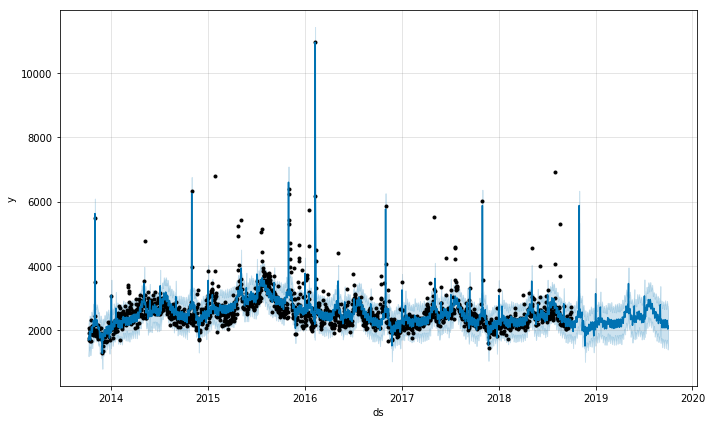

In [30]:
fig1 = m.plot(forecast)
print (' FIGURE 6')
print("Graph of Chipotle Trends with the FB Prophet Forecast Tool")

In [31]:
print ('This graph appears to capture more of the black dots in the light blue 95% confidence interval. There still is error as       portrayed by the dark blue line ')

This graph appears to capture more of the black dots in the light blue 95% confidence interval. There still is error as       portrayed by the dark blue line 


#### The following graphs represent the components of the forecasted model. The first graph is the overal trend, the second graph represents the holidays.The third graph represents the weekly trend of search interest. The final graph is the predicted trend for the next calendar year.

FIGURE 7


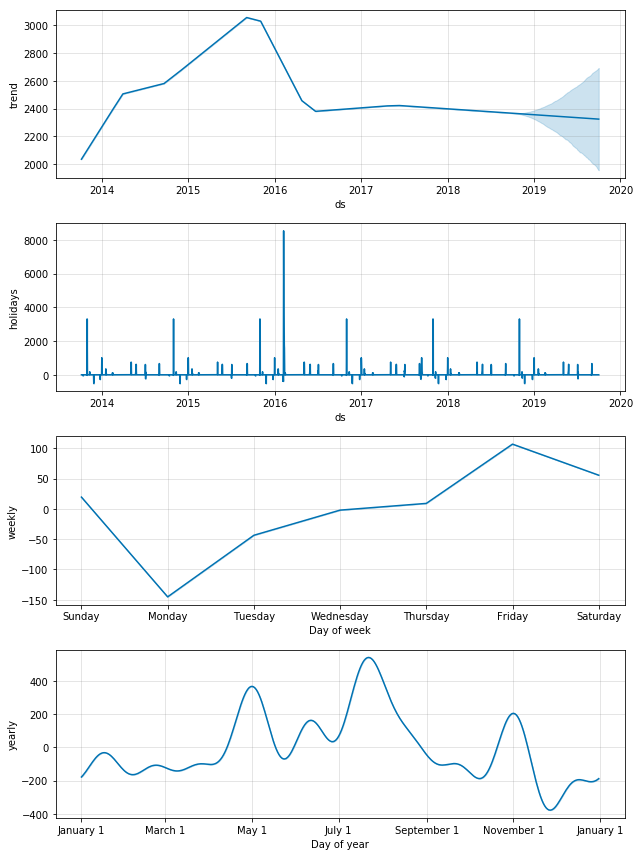

In [32]:
print ('FIGURE 7')
fig = m.plot_components(forecast)

#### Analyzing the amount of error in the model. By evaluating the value of the residuals and dividing by the length of the error there will be an error term.

In [33]:
erroranalysis = m.predict(prophetdataframe)
erroranalysis['value']= prophetdataframe['y']
erroranalysis['residuals'] = erroranalysis['value'] - erroranalysis['yhat']
erroranalysis['absoluteresidual'] =  abs(erroranalysis['residuals'])
totalerror = erroranalysis['absoluteresidual'].sum()
print(totalerror/len(erroranalysis))

227.31219582473256


#### This code below shows the top 10 residuals of the model. These are the dates where the observed value was much higher or lower than expected. In the case of Chipotle all of these outliers are higher than predicted. To further understant why these outliers are present, I researched news stories surrounding these dates.  There was a student promotion that ran on August 8th, 2018. July 31st, 2018 was national guacamole day.  On January 26th, 2015, Chipotle gave away free burritos for their Sofritas launch. January 15th, 2016 was the day Chipotle announced they would be closing all stores for the safety meeting later that year.  There were several news stories run on May 2nd, 2017 that related to Chipotle but no common theme. April 24th, 2015 was the day that Chipotle announced it's partnership with Postmates. The remaining outliers are related to the Ecoli outbreaks.  It is possible that incorporating some of these predictable special events would have improved our error analysis. However, many of them do not seem to be viewed as popular or repetitive. 

In [34]:
print(erroranalysis.nlargest(10,'absoluteresidual'))

             ds        trend   yhat_lower   yhat_upper  trend_lower  \
476  2015-01-26  2751.112441  2085.334606  2996.788336  2751.112441   
1758 2018-07-31  2374.143783  2294.498580  3254.160484  2374.143783   
756  2015-11-02  3029.289984  2629.797161  3547.766761  3029.289984   
830  2016-01-15  2789.033511  2402.160130  3353.055584  2789.033511   
1303 2017-05-02  2420.352611  2239.849874  3195.246587  2420.352611   
1776 2018-08-18  2372.056569  2069.853201  3075.030240  2372.056569   
755  2015-11-01  3029.732516  2740.584950  3719.183708  3029.732516   
757  2015-11-03  3028.847453  2712.863786  3689.223208  3028.847453   
792  2015-12-08  2913.868355  2116.651355  3075.138006  2913.868355   
564  2015-04-24  2871.555144  2754.571272  3755.513631  2871.555144   

      trend_upper  Chipotle Queso Realease  Chipotle Queso Realease_lower  \
476   2751.112441                      0.0                            0.0   
1758  2374.143783                      0.0                      

# Analysis of FB Prophet Time Series
### In the above blocks of code, I conducted a forecast using FB Prophet Tool. The first section does not incorporate holidays or special events but the second section does. It seems that incorporating these special events helps to improve our error. 

### Question 1-  How accurate does the model appear to be?
#### When examing the forecast graph (Figure 6) the model appears to be somewhat accurate. The graph shows a large majority of our observed values (black dots) within the light blue confidence interval. However, there still is a noticeable amount that are outside of this confidence range. Additionally, when testing the error of the model, I get 227 which is less than the first forecast, but still considerable.

### Question 2 - Are the residuals consistent across time? If not, why do you think it varies?
#### When looking at the output of the 10 largest residuals , there doesn't seems to be any consistency of time. However, a large majority of the highest residual values seem to come from late October and early November of 2015. Outside of that, there are very few residual values that seem to follow a common time trend. This is probably due to the fact they are true outliers that can't be predicted or are not influenced by special events. 

### Question 3- What are the project high & low interest times?
#### The 4th graph in Figure 7 exemplifies the projected search interest over the next calendar year. From this graph, it seems that the first moment of high interest is around the end of April and early May. The second main high interest time is early July and finally there is a lot of interest in the end of October and early November. From a marketing standpoint, these are times when potential consumers are searching for Chipotle and are potentially interested in consuming the product. This should be leveraged to generate revenue for Chipotle. Marketers should target users who have searched for Chipotle with advertisments or promotions to drive them to the store. There are also some periods of low or steady interest.The winter months, late summer and mid-November seem to be a down period for Chipotle search interest. Marketers could leverage these insights in two ways. First, they could heavily target during these months to increase interest and potential conversions. Second, they could perform more analyis with budget constraints in mind and determine if they should slow down their advertising during these times. Perhaps, Chipotle will never be profitable during these months and they should conserve the marketing budget for times where Chipotle is more likely to be profitable.

# Introduction of Ad Spend Data & Granger Causality
##### In the following section, I will introduce data that contains information on how Chipotle is spending their advertising dollars. This dataset covers the same time period as the previous dataset in order to perform Granger Causality. Granger causality tells us if time series A causes time series B to happen. In this example, I will examine if ad spend influences google search interest. This dataset is at the weekly level so I will resample the Google Trends data to be at the weekly level

In [35]:
adspend = pd.read_csv('chipotle.adspend.csv')

In [36]:
##Clean Up the Columns so analysis is able to be preformed.
adspend['TIME PERIOD'] = adspend['TIME PERIOD'].str.replace("WEEK OF", "",regex=True)
adspend['TIME PERIOD'] = adspend['TIME PERIOD'].str.replace(" \(B\)", "",regex=True)  
adspend.columns= adspend.columns.str.replace(" DOLS \(000\)", "",regex=True)

In [37]:
adspend['FIXED TIME'] = pd.to_datetime(adspend['TIME PERIOD']) #make the date a datetime stamp

In [38]:
adspendnoproducts = adspend.pivot_table(index='FIXED TIME',aggfunc=np.sum) #index around the date

In [39]:
list(adspendnoproducts)

['CABLE TV',
 'MAGAZINES',
 'NAT SPOT RADIO',
 'NATL NEWSP',
 'NETWORK TV',
 'NEWSPAPER',
 'OUTDOOR',
 'SPOT TV',
 'TOTAL']

#### The following graphs show the trend of specific ad expenditures throughout the time period of the dataset. Graph 1 is Cable Tv, Graph 2 is Newspaper, Graph 3 is spot tv, the fourth graph is total Ad Spend

FIGURE 8
The following graphs showcase the amount of ad expenditure for Cable Tv, Newspaper, Spot Tv and overall Ad Spend


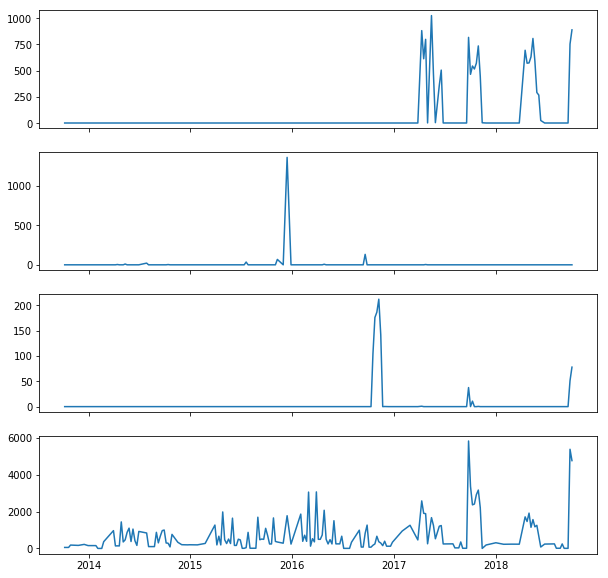

In [40]:
dimensions = (10,10)
fig, (ax1, ax2, ax3, ax4) = pyplot.subplots(4, figsize = dimensions, sharex = 'all')
print('FIGURE 8')
print('The following graphs showcase the amount of ad expenditure for Cable Tv, Newspaper, Spot Tv and overall Ad Spend')
ax1.plot(adspendnoproducts.index, adspendnoproducts['CABLE TV'])
ax2.plot(adspendnoproducts.index, adspendnoproducts['NEWSPAPER'])
ax3.plot(adspendnoproducts.index, adspendnoproducts['SPOT TV'])  ##spot tv- Regional TV on broadcast television. 
ax4.plot(adspendnoproducts.index, adspendnoproducts['TOTAL'])

In [41]:
chipotle = pd.read_csv('Chipotle_GoogleTrends.csv',parse_dates = ['period']) # read in our Google Trend Data
chipotle.set_index('period', inplace=True)
chipotle.head()

,date,value,onediffvalue
period,,,
2013-10-07,Oct 07 2013,1718.421074,NaN
2013-10-08,Oct 08 2013,1765.208236,46.787162
2013-10-09,Oct 09 2013,1906.278566,141.070331
2013-10-10,Oct 10 2013,2062.442351,156.163785
2013-10-11,Oct 11 2013,2020.565648,-41.876703


#### Below, the code will resample the data so the values are on a weekly basis. Each week will contain the average value of Google search interest of that week.

In [42]:
chipotleweekly = chipotle.resample('W-MON',closed = 'left', label='left').mean() ##create a data of the average weekly trend score to match the ad spend
chipotleweekly.head()

,value,onediffvalue
period,,
2013-10-07,1940.129404,50.975013
2013-10-14,1961.695397,16.808358
2013-10-21,1980.207698,-32.096711
2013-10-28,2789.667574,14.723802
2013-11-04,1953.835322,-12.532339


In [43]:
mergedweeklydata = adspendnoproducts.join(chipotleweekly)
mergedweeklydata.head() #merge the two data frames

,CABLE TV,MAGAZINES,NAT SPOT RADIO,NATL NEWSP,NETWORK TV,NEWSPAPER,OUTDOOR,SPOT TV,TOTAL,value,onediffvalue
FIXED TIME,,,,,,,,,,,
2013-10-07,0.0,0.0,54.8,0.0,0.0,0.0,0.0,0.0,54.8,1940.129404,50.975013
2013-10-14,0.0,0.0,54.8,0.0,0.0,0.0,0.0,0.0,54.8,1961.695397,16.808358
2013-10-21,0.0,0.0,54.8,0.0,0.0,0.0,0.0,0.0,54.8,1980.207698,-32.096711
2013-10-28,0.0,0.0,31.3,0.0,0.0,0.0,152.2,0.0,183.5,2789.667574,14.723802
2013-11-25,0.0,0.0,0.0,0.0,0.0,0.0,165.4,0.0,165.4,1606.262289,-31.205545


### Visualization of Google Trends & Ad Expenditures

#### The graphs below depict the Ad Expenditures over the time period and the Google search interest.

FIGURE 9
The first graph shows the Total Amount of Ad Expenditures over our Time Period
The second graph shows the Total Amount of Google Search interest over our Time Period


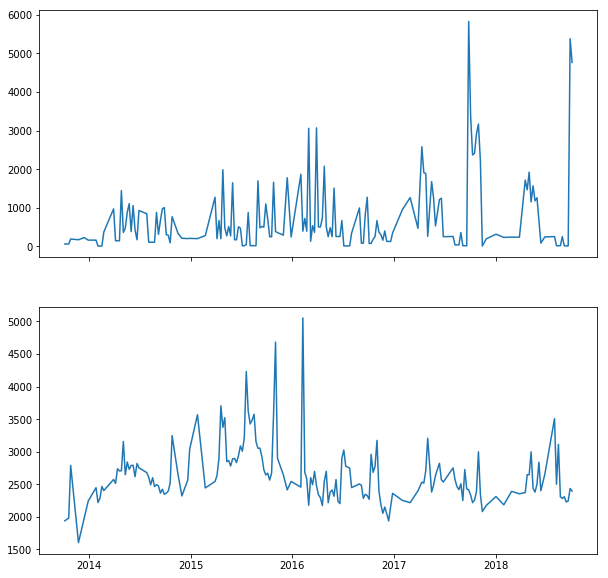

In [44]:
## Create Graphs that show a comparison of Total Ad Spend and the Google Trend Value
dimensions = (10,10)
fig, (ax1, ax2) = pyplot.subplots(2, figsize = dimensions, sharex = 'all')
print('FIGURE 9')
print ('The first graph shows the Total Amount of Ad Expenditures over our Time Period')
print('The second graph shows the Total Amount of Google Search interest over our Time Period')
ax1.plot(mergedweeklydata.index, mergedweeklydata['TOTAL']) #Graph 1 is ad$pend
ax2.plot(mergedweeklydata.index, mergedweeklydata['value']) # Graph 2 is the value of Google Trends

### Correlations between Ad Spend & Google Trends for both stationary and unstationary data

In [45]:
mergedweeklydata['TOTAL'].corr(mergedweeklydata['value']) #Test the Correlation.

-0.0708255409968122

In [46]:
mergedweeklydata['TOTALdiff']= mergedweeklydata['TOTAL'].diff(1)
mergedweeklydata['valuediff'] = mergedweeklydata['value'].diff(1)
mergedweeklydata['TOTALdiff'].corr(mergedweeklydata['valuediff']) #One Diff. Slightly improved correlation. Still not great

-0.08856383292406571

In [47]:
mergedweeklydata.to_csv('adspend.googletrends.weekly.csv')

## Correlation and Lags
##### In this section I will examine the correlation between Ad Spend & Google Trend Scores. I will also incorporate the lag component. The introduction of lag controls for the idea that spending in Week 1 will not have an effect on google trends for a set amount of weeks later.

In [48]:
adspend_trends = pd.read_csv('adspend.googletrends.weekly.csv',parse_dates = ['FIXED TIME'])#read in the CSV that contains all of the data created in the previous section
adspend_trends.set_index('FIXED TIME', inplace=True) # Fix the Index

In [49]:
adspend_trends.head() # examine the dataset

,CABLE TV,MAGAZINES,NAT SPOT RADIO,NATL NEWSP,NETWORK TV,NEWSPAPER,OUTDOOR,SPOT TV,TOTAL,value,onediffvalue,TOTALdiff,valuediff
FIXED TIME,,,,,,,,,,,,,
2013-10-07,0.0,0.0,54.8,0.0,0.0,0.0,0.0,0.0,54.8,1940.129404,50.975013,NaN,NaN
2013-10-14,0.0,0.0,54.8,0.0,0.0,0.0,0.0,0.0,54.8,1961.695397,16.808358,0.0,21.565993
2013-10-21,0.0,0.0,54.8,0.0,0.0,0.0,0.0,0.0,54.8,1980.207698,-32.096711,0.0,18.512301
2013-10-28,0.0,0.0,31.3,0.0,0.0,0.0,152.2,0.0,183.5,2789.667574,14.723802,128.7,809.459876
2013-11-25,0.0,0.0,0.0,0.0,0.0,0.0,165.4,0.0,165.4,1606.262289,-31.205545,-18.1,-1183.405285


In [50]:
adspend_trends = adspend_trends.drop(columns = ['onediffvalue','TOTALdiff','valuediff'])

In [51]:
list(adspend_trends)

['CABLE TV',
 'MAGAZINES',
 'NAT SPOT RADIO',
 'NATL NEWSP',
 'NETWORK TV',
 'NEWSPAPER',
 'OUTDOOR',
 'SPOT TV',
 'TOTAL',
 'value']

#### Testing for stationarity by significance tests.

In [52]:
for acolumn in list(adspend_trends):
    adf_result = stattools.adfuller(adspend_trends[acolumn])
    print(adf_result[1]) #stationarity significance scores for each column 
    #VALUE, NAT spot radio and cable tv are not stationary 

0.7149015416847396
0.0003476521042375153
0.3244689989481361
3.852658416229987e-12
4.288604416460474e-05
3.6995114334025364e-25
3.3778211488623325e-07
0.0004043517531728217
1.5072446229614715e-05
0.028156629413566593


#### The data is currently not stationary, so I must make it stationary.

In [53]:
adspend_trends_diff = pd.DataFrame() # Initialize a DataFrame that will hold the differentiated results

In [54]:
for acolumn in list(adspend_trends):
    columnname = "%s_diff" % (acolumn)
    adspend_trends_diff[columnname] = adspend_trends[acolumn].diff(1) # populate the dataframe with Differentiated values

In [55]:
adspend_trends_diff.head()

,CABLE TV_diff,MAGAZINES_diff,NAT SPOT RADIO_diff,NATL NEWSP_diff,NETWORK TV_diff,NEWSPAPER_diff,OUTDOOR_diff,SPOT TV_diff,TOTAL_diff,value_diff
FIXED TIME,,,,,,,,,,
2013-10-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.565993
2013-10-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.512301
2013-10-28,0.0,0.0,-23.5,0.0,0.0,0.0,152.2,0.0,128.7,809.459876
2013-11-25,0.0,0.0,-31.3,0.0,0.0,0.0,13.2,0.0,-18.1,-1183.405285


In [56]:
for acolumn in list(adspend_trends_diff):
    adf_result = stattools.adfuller(adspend_trends_diff[acolumn].iloc[1:])
    print(adf_result[1]) #stationarity significance scores for each column 

    
print('Can conclude that our entire DataSet is stationary')

5.6187663503487845e-09
1.5297819689260008e-09
3.928421443282114e-05
2.1872765732855514e-12
8.555604173426525e-05
3.848321645070926e-13
4.495159433538989e-10
5.518959681844407e-09
3.2963435163546146e-08
4.771503117940149e-19
Can conclude that our entire DataSet is stationary


In [57]:
correlationlist = []
for acolumn in list(adspend_trends_diff):
    if "value" not in acolumn:
        corr = adspend_trends_diff[acolumn].corr(adspend_trends_diff['value_diff'])
        print(acolumn, corr)
        correlationlist.append(corr)  #correlation between value_diff and variables for staionarity data

CABLE TV_diff -0.043657897435965876
MAGAZINES_diff -0.019864746467652863
NAT SPOT RADIO_diff -0.07880258347715516
NATL NEWSP_diff -0.07341124723800938
NETWORK TV_diff 0.007023751427050116
NEWSPAPER_diff -0.04588833075581282
OUTDOOR_diff -0.11621448711123027
SPOT TV_diff 0.004170778438515734
TOTAL_diff -0.08856383292406561


In [58]:
np.mean(correlationlist) ## The mean will give us a sense of the overall correlation

-0.05057873283825845

In [59]:
correlationlist = []
for acolumn in list(adspend_trends):
    if "value" not in acolumn:
        corr = adspend_trends[acolumn].corr(adspend_trends['value'])
        print(acolumn, corr)
        correlationlist.append(corr)  ##repeat but with the un-differentiated, non-stationary data

CABLE TV -0.09182979593695653
MAGAZINES 0.14214885838623054
NAT SPOT RADIO 0.08115673055457469
NATL NEWSP -0.0439426818469695
NETWORK TV -0.10819361571829325
NEWSPAPER -0.03086103119126
OUTDOOR -0.02564950853647562
SPOT TV -0.008410164197795503
TOTAL -0.07082554099681207


In [60]:
print(np.mean(correlationlist))
print('This correlation value is lower than the stationary data thus I can conclude that the stationary data works better')

-0.01737852772041747
This correlation value is lower than the stationary data thus I can conclude that the stationary data works better


#### Visualization of Correlation

This heatmap showcases the correlation between pairs of variables. I am mainly interested in how the "Value_Diff" variable
correlates with the ad expenditure variables. The lighter blue the closer the correlation to 1. From this visualization,
it looks as if Magazines,Network Tv, and Spot Tv have the highest correlations but they are still very low.


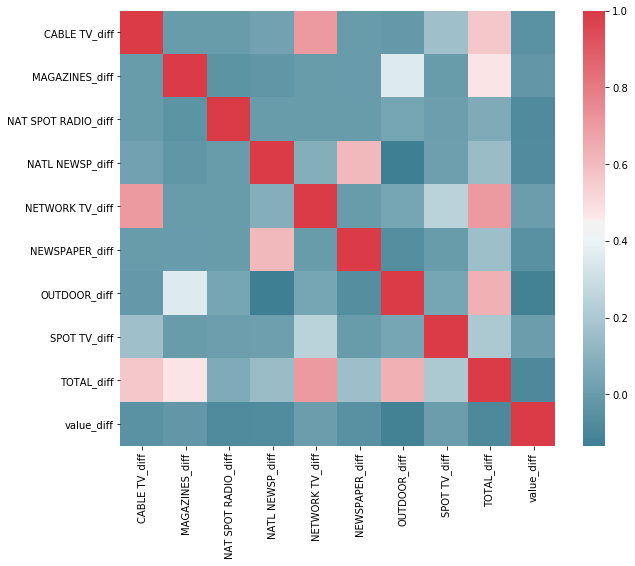

In [61]:
f, ax = pyplot.subplots(figsize = (10,8))
corr = adspend_trends_diff.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),cmap=sns.diverging_palette(220,10, as_cmap=True),
            square=True,ax = ax)
print('This heatmap showcases the correlation between pairs of variables. I am mainly interested in how the "Value_Diff" variable')
print('correlates with the ad expenditure variables. The lighter blue the closer the correlation to 1. From this visualization,')
print('it looks as if Magazines,Network Tv, and Spot Tv have the highest correlations but they are still very low.')

#### Incorporating Lag
##### In the following code blocks, I will incorporate the lag feature. Lag is the idea that an event in week 1 (spending money on ads) will cause an event to happen in week 3 ( google search interest).

In [62]:
print('These results will tell us at which week interval each category of ad expenditure has a significant effect on Google Trends Values.')
print('                                       ')
numofweeks = 8
significantlags = []
for acolumn in list(adspend_trends_diff):
    if 'value' not in acolumn:
        testframe = adspend_trends_diff[['value_diff',acolumn]]
        testframe = testframe.iloc[1:]
        results = stattools.grangercausalitytests(testframe,numofweeks, verbose=False)
        for week in range(1,numofweeks+1):
            if results[week][0]['params_ftest'][1] <.05:
                print('%s is signficant at %s weeks' % (acolumn, week))
                significantlags.append(week)


These results will tell us at which week interval each category of ad expenditure has a significant effect on Google Trends Values.
                                       
MAGAZINES_diff is signficant at 1 weeks
MAGAZINES_diff is signficant at 2 weeks
MAGAZINES_diff is signficant at 3 weeks
MAGAZINES_diff is signficant at 4 weeks
MAGAZINES_diff is signficant at 6 weeks
MAGAZINES_diff is signficant at 7 weeks
MAGAZINES_diff is signficant at 8 weeks
NAT SPOT RADIO_diff is signficant at 1 weeks
NAT SPOT RADIO_diff is signficant at 2 weeks
NAT SPOT RADIO_diff is signficant at 3 weeks
NAT SPOT RADIO_diff is signficant at 4 weeks
NAT SPOT RADIO_diff is signficant at 5 weeks
NAT SPOT RADIO_diff is signficant at 6 weeks
NAT SPOT RADIO_diff is signficant at 7 weeks
NAT SPOT RADIO_diff is signficant at 8 weeks
NATL NEWSP_diff is signficant at 2 weeks
NATL NEWSP_diff is signficant at 3 weeks
NATL NEWSP_diff is signficant at 4 weeks
NATL NEWSP_diff is signficant at 5 weeks
NATL NEWSP_diff is signf

In [63]:
print ('Mode of Significant Lags. This is the most common occurence of number of weeks of significance')
print ('   ')
print(mode(significantlags))
print('    ')
print('Mean of Significant Lags.The average number of weeks that ad expenditure is significant')
print('      ')
print(np.mean(significantlags))
print ('        ')
print ('Median of Significant Lags')
print ('   ')
print(np.median(significantlags))


Mode of Significant Lags. This is the most common occurence of number of weeks of significance
   
2
    
Mean of Significant Lags.The average number of weeks that ad expenditure is significant
      
4.285714285714286
        
Median of Significant Lags
   
4.0


In [64]:
modelingdataset = adspend_trends_diff # create a copy of the dataset

In [65]:
modelingdataset.tail()

,CABLE TV_diff,MAGAZINES_diff,NAT SPOT RADIO_diff,NATL NEWSP_diff,NETWORK TV_diff,NEWSPAPER_diff,OUTDOOR_diff,SPOT TV_diff,TOTAL_diff,value_diff
FIXED TIME,,,,,,,,,,
2018-09-03,0.0,0.0,-3.4,0.0,0.0,0.0,-236.9,0.0,-240.3,26.583318
2018-09-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-79.966253
2018-09-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.896752
2018-09-24,752.4,0.0,0.0,128.3,4443.5,0.0,0.0,51.1,5375.5,192.925832
2018-10-01,135.6,0.0,7.2,-128.3,-983.1,0.0,326.6,26.8,-615.2,-39.221084


#### Implenting Lag into the Dataset. The mode or most common occurence is 2 weeks. The mean is 4.2 weeks and the median is 4 weeks. I will add four weeks onto our dataset that will allow us to predict the values at a 4 week lag.  The reason for selecting 4 weeks is that the majority of variables surpassed this number.

In [66]:
##adding in Four Additional Weeks
date = pd.to_datetime('2018-10-08')
modelingdataset.loc[date] = np.nan 
date = pd.to_datetime('2018-10-15')
modelingdataset.loc[date] = np.nan
date = pd.to_datetime('2018-10-22')
modelingdataset.loc[date] = np.nan
date = pd.to_datetime('2018-10-29')
modelingdataset.loc[date] = np.nan

In [67]:
#rename the columns to represent the lag
for acolumn in list(modelingdataset):
    if 'value' not in acolumn:
        for alag in range(1, 5):
            columnname = '%s_lag%s' % (acolumn, alag)
            modelingdataset[columnname]= modelingdataset[acolumn].shift(alag)

In [68]:
modelingdataset.sort_index(axis=1,inplace=True)
modelingdataset.tail()

,CABLE TV_diff,CABLE TV_diff_lag1,CABLE TV_diff_lag2,CABLE TV_diff_lag3,CABLE TV_diff_lag4,MAGAZINES_diff,MAGAZINES_diff_lag1,MAGAZINES_diff_lag2,MAGAZINES_diff_lag3,MAGAZINES_diff_lag4,...,SPOT TV_diff_lag1,SPOT TV_diff_lag2,SPOT TV_diff_lag3,SPOT TV_diff_lag4,TOTAL_diff,TOTAL_diff_lag1,TOTAL_diff_lag2,TOTAL_diff_lag3,TOTAL_diff_lag4,value_diff
FIXED TIME,,,,,,,,,,,,,,,,,,,,,
2018-10-01,135.6,752.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,51.1,0.0,0.0,0.0,-615.2,5375.5,0.0,0.0,-240.3,-39.221084
2018-10-08,NaN,135.6,752.4,0.0,0.0,NaN,0.0,0.0,0.0,0.0,...,26.8,51.1,0.0,0.0,NaN,-615.2,5375.5,0.0,0.0,NaN
2018-10-15,NaN,NaN,135.6,752.4,0.0,NaN,NaN,0.0,0.0,0.0,...,NaN,26.8,51.1,0.0,NaN,NaN,-615.2,5375.5,0.0,NaN
2018-10-22,NaN,NaN,NaN,135.6,752.4,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,26.8,51.1,NaN,NaN,NaN,-615.2,5375.5,NaN
2018-10-29,NaN,NaN,NaN,NaN,135.6,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,26.8,NaN,NaN,NaN,NaN,-615.2,NaN


In [69]:
modelingdataset.to_csv('google_adspend_differenced_laged_fordatarobot.csv') ## create a CSV of this Data set in the instances we want to incorporate Datarobot into our analysis

## Granger Causality- LASSOLARS
##### I will use a Linear Regression with a LassoLars penalty to understand the Granger Causality between Ad Spend and Google Searches. I am attempting to answer if changes in Ad Expenditures cause changes in Google Trend searches. LassoLars shrinks coefficents that do not add value to the model to zero in order to highlight the other coefficients. I will use a 60/40 train-test split

In [70]:
alldata = pd.read_csv('google_adspend_differenced_laged_fordatarobot.csv')

In [71]:
alldata.set_index(alldata['FIXED TIME'],inplace = True)

In [72]:
list(alldata)

['FIXED TIME',
 'CABLE TV_diff',
 'CABLE TV_diff_lag1',
 'CABLE TV_diff_lag2',
 'CABLE TV_diff_lag3',
 'CABLE TV_diff_lag4',
 'MAGAZINES_diff',
 'MAGAZINES_diff_lag1',
 'MAGAZINES_diff_lag2',
 'MAGAZINES_diff_lag3',
 'MAGAZINES_diff_lag4',
 'NAT SPOT RADIO_diff',
 'NAT SPOT RADIO_diff_lag1',
 'NAT SPOT RADIO_diff_lag2',
 'NAT SPOT RADIO_diff_lag3',
 'NAT SPOT RADIO_diff_lag4',
 'NATL NEWSP_diff',
 'NATL NEWSP_diff_lag1',
 'NATL NEWSP_diff_lag2',
 'NATL NEWSP_diff_lag3',
 'NATL NEWSP_diff_lag4',
 'NETWORK TV_diff',
 'NETWORK TV_diff_lag1',
 'NETWORK TV_diff_lag2',
 'NETWORK TV_diff_lag3',
 'NETWORK TV_diff_lag4',
 'NEWSPAPER_diff',
 'NEWSPAPER_diff_lag1',
 'NEWSPAPER_diff_lag2',
 'NEWSPAPER_diff_lag3',
 'NEWSPAPER_diff_lag4',
 'OUTDOOR_diff',
 'OUTDOOR_diff_lag1',
 'OUTDOOR_diff_lag2',
 'OUTDOOR_diff_lag3',
 'OUTDOOR_diff_lag4',
 'SPOT TV_diff',
 'SPOT TV_diff_lag1',
 'SPOT TV_diff_lag2',
 'SPOT TV_diff_lag3',
 'SPOT TV_diff_lag4',
 'TOTAL_diff',
 'TOTAL_diff_lag1',
 'TOTAL_diff_lag2',


In [73]:
alldata = alldata.drop(columns = ['FIXED TIME'])

In [74]:
alldata.head()

,CABLE TV_diff,CABLE TV_diff_lag1,CABLE TV_diff_lag2,CABLE TV_diff_lag3,CABLE TV_diff_lag4,MAGAZINES_diff,MAGAZINES_diff_lag1,MAGAZINES_diff_lag2,MAGAZINES_diff_lag3,MAGAZINES_diff_lag4,...,SPOT TV_diff_lag1,SPOT TV_diff_lag2,SPOT TV_diff_lag3,SPOT TV_diff_lag4,TOTAL_diff,TOTAL_diff_lag1,TOTAL_diff_lag2,TOTAL_diff_lag3,TOTAL_diff_lag4,value_diff
FIXED TIME,,,,,,,,,,,,,,,,,,,,,
2013-10-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-14,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,21.565993
2013-10-21,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,18.512301
2013-10-28,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,...,0.0,0.0,NaN,NaN,128.7,0.0,0.0,NaN,NaN,809.459876
2013-11-25,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,NaN,-18.1,128.7,0.0,0.0,NaN,-1183.405285


In [75]:
alldata = alldata.iloc[5:] ## remove rows with NaN that were created as a result of the lag

In [76]:
alldata.tail()

,CABLE TV_diff,CABLE TV_diff_lag1,CABLE TV_diff_lag2,CABLE TV_diff_lag3,CABLE TV_diff_lag4,MAGAZINES_diff,MAGAZINES_diff_lag1,MAGAZINES_diff_lag2,MAGAZINES_diff_lag3,MAGAZINES_diff_lag4,...,SPOT TV_diff_lag1,SPOT TV_diff_lag2,SPOT TV_diff_lag3,SPOT TV_diff_lag4,TOTAL_diff,TOTAL_diff_lag1,TOTAL_diff_lag2,TOTAL_diff_lag3,TOTAL_diff_lag4,value_diff
FIXED TIME,,,,,,,,,,,,,,,,,,,,,
2018-10-01,135.6,752.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,51.1,0.0,0.0,0.0,-615.2,5375.5,0.0,0.0,-240.3,-39.221084
2018-10-08,NaN,135.6,752.4,0.0,0.0,NaN,0.0,0.0,0.0,0.0,...,26.8,51.1,0.0,0.0,NaN,-615.2,5375.5,0.0,0.0,NaN
2018-10-15,NaN,NaN,135.6,752.4,0.0,NaN,NaN,0.0,0.0,0.0,...,NaN,26.8,51.1,0.0,NaN,NaN,-615.2,5375.5,0.0,NaN
2018-10-22,NaN,NaN,NaN,135.6,752.4,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,26.8,51.1,NaN,NaN,NaN,-615.2,5375.5,NaN
2018-10-29,NaN,NaN,NaN,NaN,135.6,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,26.8,NaN,NaN,NaN,NaN,-615.2,NaN


In [77]:
alldata = alldata.iloc[:-4] ## remove rows with NaN

#### Below, I create a list of all the predictive values. Then I create two seperate data frames that hold the predictor and target variable values.

In [78]:
listofallpredictors = []
for avar in list(alldata):
    if 'value' not in avar:
        listofallpredictors.append(avar)
##create a list that contains all of the predictor variables- not VALUE     

In [79]:
predictors = alldata[listofallpredictors] #create a dataframe that includes all the predictors
target = alldata['value_diff'] #create a dataframe that includes the target variable values

#### First, I will split the data into training and test sets using a 60/40 split. I then will fit the model.

In [80]:
pred_train,pred_test,tar_train,tar_test = train_test_split(predictors,target,test_size=.4,random_state=88) # split the data into a test & Training set

In [81]:
model = LassoLarsCV(cv=10,precompute=False) # initialize the model

In [82]:
model = model.fit(pred_train.values,tar_train.values) #fit the model to the training values

#### In the following two blocks of code, I will create a list of the coefficients that are positively affecting the google search interest value. 

In [83]:
predictors_model=pd.DataFrame(listofallpredictors)
predictors_model.column = ['label']
predictors_model['coeff']=model.coef_

In [84]:
for index, row in predictors_model.iterrows():
    if row['coeff'] >0:
        print (row.values) #showcase the significant predictors

['CABLE TV_diff_lag3' 0.08654681461078767]
['MAGAZINES_diff' 0.2399427665114419]
['MAGAZINES_diff_lag1' 0.24992300738918943]
['MAGAZINES_diff_lag4' 0.0011366607838918703]
['NAT SPOT RADIO_diff_lag1' 0.9638578562443737]
['NATL NEWSP_diff_lag3' 0.5177627541003224]
['NEWSPAPER_diff_lag3' 1.3415659328474454]
['SPOT TV_diff' 0.6874907076010728]
['SPOT TV_diff_lag2' 0.2269153557741367]
['TOTAL_diff_lag1' 0.00389708124902306]


#### Below, I will calculate scores for the Mean Squared Error & R-squared for both the test and training sets. These are methods of ensuring our model is accuracte. I am aiming for a MSE close to zero and an R-squared close to 1.

In [85]:
train_error = mean_squared_error(tar_train,model.predict(pred_train))
print('training data MSE')
print (train_error ) 

training data MSE
110104.05738397337


In [86]:
test_error = mean_squared_error(tar_test,model.predict(pred_test))
print('test data MSE')
print (test_error )

test data MSE
94805.58150844644


In [87]:
rsquared_train = model.score(pred_train,tar_train)
print ('training data r-square')
print(rsquared_train)

training data r-square
0.5959101846398702


In [88]:
rsquared_test = model.score(pred_test,tar_test)
print ('test data r-square')
print(rsquared_test)
print('This is an unbalanced model.It is very possible that there is no Granger Causality Present here')

test data r-square
-0.16449134497381346
This is an unbalanced model.It is very possible that there is no Granger Causality Present here


## Additonal Attempts with Granger Causality
#### Use of Ridge Regression
##### Ridge Regression is similar to LassoLars but it doesn't entirely shrink all coefficents to zero. I will use the same data as the LassoLars but use a Ridge Regression

In [89]:
rr = Ridge(alpha=100)  ##fit the model 
rr.fit(pred_train.values,tar_train.values)

Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [90]:
Ridge_train_score100 = rr.score(pred_train,tar_train)
print('training data r-squared')
print(Ridge_train_score100)
Ridge_test_score100 = rr.score(pred_test, tar_test)
print('test data r-squared')
print(Ridge_test_score100)
print('This is an unbalanced model.It is very possible that there is no Granger Causality Present here')

training data r-squared
0.6693682405316418
test data r-squared
-2.9950846658082066
This is an unbalanced model.It is very possible that there is no Granger Causality Present here


In [91]:
## mean squared error
train_error = mean_squared_error(tar_train,rr.predict(pred_train))
print('training data MSE')
print (train_error ) 

training data MSE
90088.63087782747


In [92]:
test_error = mean_squared_error(tar_test,rr.predict(pred_test))
print('test data MSE')
print (test_error )

test data MSE
325254.7359430497


# Analysis of Ad Spend & Granger Causality

##### In the above section, I imported Chipotle's Ad expenditure data and merged it with the google trend data. I created a lag component that takes the assumption that ad expenditure takes time to have an effect on Google search interest. I then performed correlations, visual analysis, LassoLars Regression, and Ridge Regression to test if there was evidence of Granger Causality.

### Question 1 - Do any advertising expenditures drive Google search interest?
#### The best way to answer this question is to analyze the coefficent output from the LassoLars Regression. In the code, I printed the significant coefficents that were driving Google search interest. They are as follows:
 ['CABLE TV_diff_lag3' 0.08654681461078767]
['MAGAZINES_diff' 0.2399427665114419]
['MAGAZINES_diff_lag1' 0.24992300738918943]
['MAGAZINES_diff_lag4' 0.0011366607838918703]
['NAT SPOT RADIO_diff_lag1' 0.9638578562443737]
['NATL NEWSP_diff_lag3' 0.5177627541003224]
['NEWSPAPER_diff_lag3' 1.3415659328474454]
['SPOT TV_diff' 0.6874907076010728]
['SPOT TV_diff_lag2' 0.2269153557741367]
['TOTAL_diff_lag1' 0.00389708124902306]
#### Some of these coefficent values are higher than others. They can be interpreted as for each unit increase in ad spending, one could expect on average the google trend search interest value to increase by the value of the coefficent. So for example, for each unit increase in Cable TV spending, the average value of Google Trend search would rise by 0.0865 at a three week lag. From this output, it is clear that newspaper advertisements have a significant impact on search interest both at the national and local/regional level. These coefficents also tell us that a newspaper advertisement will have the highest effect after three weeks. This may be due to the fact that the amount of time between purchasing the ad and the printing of the ad may take three weeks. The next highest coefficent is National Spot Radio at a one week lag. I would imagine that radio advertisements have a really strong effect on consumers googling Chipotle and actually converting. If a consumer is driving in their car and hear a Chipotle ad, they will be very compelled to search for the nearest Chipotle and buy a burrito on their road trip. I would suggest investing in this area of advertising as it has the potential to drive revenue for Chipotle. I was very surprised to see that Outdoor advertising such as billboards were not included in this list of coefficents. I originally hypothesized that billboards may be a huge driver of revenue and search interest for Chipotle as consumers on roads are often looking for somewhere to stop and eat. It is possible that it does have a large effect on both revenue and search interest but was excluded due to the lag being longer than four weeks. Additionally, a billboard may include directions to the nearest Chipotle and consumers do not need to search and therefore influence the google search interest value. However, these insights should be taken with a grain of salt because our model is very unbalanced, there is a very high MSE and a negative R-Squared. In other words, there may not be granger causality present here and it is possible that ad expenditures don't influence google search interest. This is potentially due to the product at hand, a momentary decision to choose to eat at Chipotle, often does not require research and constant googling that may happen with larger purchases.

### Question 2-Create time series visualizations that overlay both ad spend and Google search interest, to see if they visually align.
#### The visualization found in Figure 9, shows the time series of both advertising expenditures and Google search interest. From this visual alignment, there does seem to be some essence of granger causality, as the peaks are somewhat aligned. However, it does not seem to be that strong of a relationship as large peaks in ad spend do not translate to large peaks in search interest. I believe that this time series analysis and granger causality tests were strongly influenced by the outliers that do exist in the dataset. My initial thoughts about these outliers are related to the Chipotle Ecoli outbreak. 


# Granger Causality- Stock Prices & Google Search Interest
###### Google search interest can be interpreted as the awareness of the brand. If there are many news stories about a particular brand it is very probable that Google search interest will rise as the news story is revealed and circulated throughout the consumer base. I would assume that for many brands when a news story is run, the chances of this being negative press are much higher than the chances of it being positive press. There were also many news stories run about Chipotle when they were dealing with the Ecoli outbreaks. I wanted to see if popularity or the amount of search queries caused change in stock prices. I used the mergent online database to pull daily stock prices from October 7th,2013- October 1st 2018. In the following blocks of code, I will resample the data to be on a weekly basis, with the average stock price for that week. I will also perform correlations between the stock prices and search values as well as showcase visualizations. 

In [93]:
chipotle2 = chipotleweekly

In [94]:
stock = pd.read_csv('Chipotle Stock Prices.csv',parse_dates=['Date'])

In [95]:
stock= stock.set_index(['Date'])
stock.index = pd.to_datetime(stock.index)

In [96]:
stock.head()

,Stock Price
Date,
2013-10-07,433.40
2013-10-08,427.72
2013-10-09,428.67
2013-10-10,435.87
2013-10-11,443.61


In [97]:
logic = {'Average'  : 'mean'}

offset = pd.offsets.timedelta(days=-6)

stockweekly = stock.resample('W', loffset=offset).apply(logic)

In [98]:
mergedstockdata = stockweekly.join(chipotle2)
mergedstockdata.head()

,"(Average, Stock Price)",value,onediffvalue
Date,,,
2013-10-07,433.854,1940.129404,50.975013
2013-10-14,452.502,1961.695397,16.808358
2013-10-21,520.102,1980.207698,-32.096711
2013-10-28,526.940,2789.667574,14.723802
2013-11-04,535.616,1953.835322,-12.532339


In [99]:
mergedstockdata.columns = ['AVG STOCK','value','onediffvalue']

FIGURE 11
The first graph shows the Stock Prices over our Time Period
The second graph shows the Total Amount of Google Search interest over our Time Period


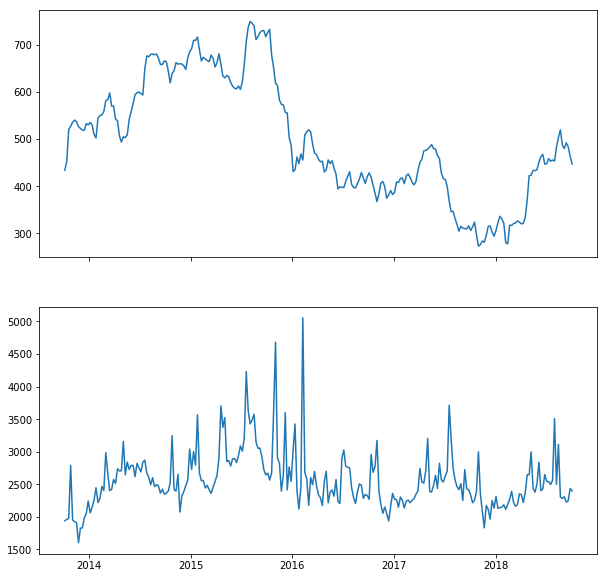

In [100]:
dimensions = (10,10)
fig, (ax1, ax2) = pyplot.subplots(2, figsize = dimensions, sharex = 'all')
print('FIGURE 11')
print ('The first graph shows the Stock Prices over our Time Period')
print('The second graph shows the Total Amount of Google Search interest over our Time Period')
ax1.plot(mergedstockdata.index, mergedstockdata['AVG STOCK']) #Graph
ax2.plot(mergedstockdata.index, mergedstockdata['value'])

In [101]:
mergedstockdata['AVG STOCK'].corr(mergedstockdata['value'] )

0.3827976741581801

In [102]:
mergedstockdata['STOCKdiff']= mergedstockdata['AVG STOCK'].diff(1)
mergedstockdata['valuediff'] = mergedstockdata['value'].diff(1)

In [103]:
mergedstockdata['STOCKdiff'].corr(mergedstockdata['valuediff'])

-0.15666400100668626

In [104]:
stock_trends = mergedstockdata

In [105]:
## Before Proceeding with Granger Causality test, see if there is stationary data 

In [106]:
stock_trends = stock_trends.drop(columns = ['onediffvalue','STOCKdiff','valuediff'])

In [107]:
for acolumn in list(stock_trends):
    adf_result = stattools.adfuller(stock_trends[acolumn])
    print(adf_result[1]) #stationarity significance scores for each column 
print('Must make data Stationary')

0.5528786613327595
0.11398265325363338
Must make data Stationary


In [108]:
stock_trends_diff = pd.DataFrame()

In [109]:
for acolumn in list(stock_trends):
    columnname = "%s_diff" % (acolumn)
    stock_trends_diff[columnname] = stock_trends[acolumn].diff(1)

In [110]:
stock_trends_diff.head()

,AVG STOCK_diff,value_diff
Date,,
2013-10-07,NaN,NaN
2013-10-14,18.648,21.565993
2013-10-21,67.600,18.512301
2013-10-28,6.838,809.459876
2013-11-04,8.676,-835.832252


In [111]:
## Check for stationarity
for acolumn in list(stock_trends_diff):
    adf_result = stattools.adfuller(stock_trends_diff[acolumn].iloc[1:])
    print(adf_result[1]) #stationarity significance scores for each column 
print('Data is stationary')

7.512689994925894e-22
0.001756658332572005
Data is stationary


In [112]:
correlationlist = []
for acolumn in list(stock_trends_diff):
    if "value" not in acolumn:
        corr = stock_trends_diff[acolumn].corr(stock_trends_diff['value_diff'])
        print(acolumn, corr)
        correlationlist.append(corr)

AVG STOCK_diff -0.15666400100668626


In [113]:
alldata=stock_trends_diff

## Granger Causality with LassoLars
### I will use a LassoLars penalty to perform a linear regression on the relationship between stock prices and search interest. I will use a 60/40 train test split in order to receive the best results on our data.


In [114]:
list(alldata)
##The time is the index so we are all set

['AVG STOCK_diff', 'value_diff']

In [115]:
alldata=alldata.iloc[1:] # remove Nan Values that were created from differntiating the data

In [116]:
alldata.head()

,AVG STOCK_diff,value_diff
Date,,
2013-10-14,18.648,21.565993
2013-10-21,67.600,18.512301
2013-10-28,6.838,809.459876
2013-11-04,8.676,-835.832252
2013-11-11,4.450,-25.818794


In [117]:
listofallpredictors = []
for avar in list(alldata):
    if 'value' in avar:
        listofallpredictors.append(avar)


In [118]:
predictors = alldata[listofallpredictors]

In [119]:
target = alldata['AVG STOCK_diff']

In [120]:
pred_train,pred_test,tar_train,tar_test = train_test_split(predictors,target,test_size=.4,random_state=88) #using a 60/40 split

In [121]:
model = LassoLarsCV(cv=10,precompute=False)

In [122]:
model = model.fit(pred_train.values,tar_train.values)

In [123]:
predictors_model=pd.DataFrame(listofallpredictors)
predictors_model.column = ['label']
predictors_model['coeff']=model.coef_

In [124]:
for index, row in predictors_model.iterrows():
        print (row.values)

['value_diff' -0.008528886039280733]


In [125]:
train_error = mean_squared_error(tar_train,model.predict(pred_train))
print('training data MSE')
print (train_error )

training data MSE
326.67742792999644


In [126]:
test_error = mean_squared_error(tar_test,model.predict(pred_test))
print('test data MSE')
print (test_error )

test data MSE
241.6391583135917


In [127]:
rsquared_train = model.score(pred_train,tar_train)
print ('training data r-square')
print(rsquared_train)

training data r-square
0.04764368652165207


In [128]:
rsquared_test = model.score(pred_test,tar_test)
print ('test data r-square')
print(rsquared_test) 

test data r-square
-0.03707384767063848


# Analysis of Relationship Between Search Interest & Stock Prices
##### After performing this Granger Causality as well as correlation tests, there seems to be a small effect of search interest on stock prices. When looking at the coefficent output from the LassoLars regression, Thre is a negative value for the value of the search interest. This can be interpreted as for each unit increase in search interest, so there is  an expected -0.008 decrease in the differentiated value of the stock price. In other words for the higher amounts of search interest,  the stock price  is expected to decrease.  This is very important to understand from a business and marketing perspective. If there is a controversy or scandal, such as the Ecoli Outbreak, it is very important to understand that stock prices may decrease and thus the valuation goes down. From a quality standpoint, it is very important to maintain the quality of the food products being served. From a marketing & pr standpoint, it is very wise to have a plan in action in the instance of these situations. With proper handling of communication surrounding scandals, the news stories can be suppressed and search interest may decline as well.